In [1]:
!pip install gdown
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 5.8 MB/s eta 0:00:00


In [2]:
!gdown 1rtpnx9w3go_XMwjzips4wO8P0p-e__DT

Downloading...
From (original): https://drive.google.com/uc?id=1rtpnx9w3go_XMwjzips4wO8P0p-e__DT
From (redirected): https://drive.google.com/uc?id=1rtpnx9w3go_XMwjzips4wO8P0p-e__DT&confirm=t&uuid=0f2158f1-2856-4774-8516-8a31ebdff2ce
To: /kaggle/working/consumer_complaint_dataset.data
100%|████████████████████████████████████████| 173M/173M [00:04<00:00, 35.8MB/s]


In [3]:
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
df_complaint = pd.read_pickle('/kaggle/working/consumer_complaint_dataset.data', compression='gzip')

In [5]:
df_complaint

,topic,input
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...
4,"Credit reporting, credit repair services, or o...",I have several accounts that the balance is in...
...,...,...
492250,Consumer Loan,I was on automatic payment for my car loan. In...
492251,Debt collection,I recieved a collections call from an unknown ...
492252,Mortgage,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who..."
492253,Mortgage,I can not get from chase who services my mortg...


In [6]:
df_complaint.loc[df_complaint['topic']=='Credit reporting', 'topic'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df_complaint.loc[df_complaint['topic']=='Credit card', 'topic'] = 'Credit card or prepaid card'
df_complaint.loc[df_complaint['topic']=='Prepaid card', 'topic'] = 'Credit card or prepaid card'
df_complaint.loc[df_complaint['topic']=='Payday load', 'topic'] = 'Payday loan, title loan, or personal loan'
df_complaint.loc[df_complaint['topic']=='Virtual currency', 'topic'] = 'Money transfer, virtual currency, or money service'
df_complaint.loc[df_complaint['topic']=='Money transfers', 'topic'] = 'Money transfer, virtual currency, or money service'
df_complaint = df_complaint[df_complaint['topic'] != 'Other financial service']

In [7]:
df_complaint

,topic,input
0,Debt collection,transworld systems inc. \nis trying to collect...
1,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...
2,Debt collection,"Over the past 2 weeks, I have been receiving e..."
3,"Credit reporting, credit repair services, or o...",I HAD FILED WITH CFPB ON XX/XX/XXXX19 TO HAVE ...
4,"Credit reporting, credit repair services, or o...",I have several accounts that the balance is in...
...,...,...
492250,Consumer Loan,I was on automatic payment for my car loan. In...
492251,Debt collection,I recieved a collections call from an unknown ...
492252,Mortgage,"On XXXX XXXX, 2015, I contacted XXXX XXXX, who..."
492253,Mortgage,I can not get from chase who services my mortg...


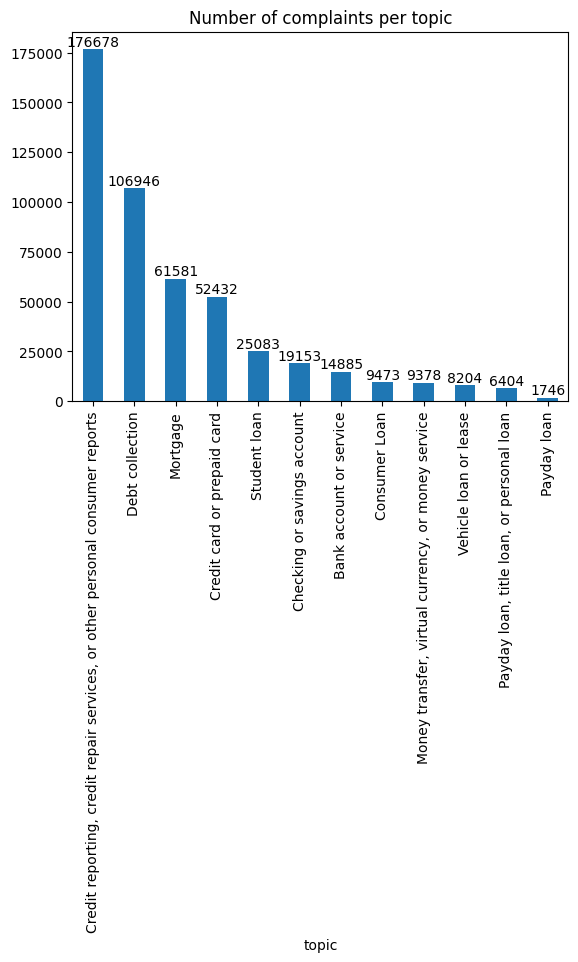

In [8]:
data = df_complaint['topic'].value_counts().sort_values(ascending=False)

data.plot(kind='bar', title='Number of complaints per topic')

for index, value in enumerate(data):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

## Function to retrieve text

In [9]:
def print_plot(index):
  example = df_complaint[df_complaint.index == index][['input','topic']].values[0]
  if len(example)>0:
    print(example[0])
    print('Topic: ',example[1])
print_plot(10)

XXXX is reporting incorrectly to Equifax and XXXX an account balance of {$2300.00} on the XXXX partial account number XXXX. ( Please see pages 12 and 13 of the attached credit report ). This account is over 7 years old and therefore should not be on my credit report. This incorrect reporting is harming my credit score and is a Fair Credit Reporting Act ( F.C.R.A. ) violation.
Topic:  Credit reporting, credit repair services, or other personal consumer reports


## Clean Data

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
import re

REPLACE_BY_SPLACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

## Function to clean text

In [13]:
def clean_text(text):
  text = text.lower()
  text = REPLACE_BY_SPLACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub('', text)
  text = text.replace('x', '')
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text

In [14]:
df_complaint['input'] = df_complaint['input'].apply(clean_text)
df_complaint['input'] = df_complaint['input'].str.replace('\d+','')

/tmp/ipykernel_26/2033757721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complaint['input'] = df_complaint['input'].apply(clean_text)
/tmp/ipykernel_26/2033757721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complaint['input'] = df_complaint['input'].str.replace('\d+','')


In [15]:
def sample_by_group(df, group_col, n_samples):
    if isinstance(n_samples, dict):
        return df.groupby(group_col, group=True).apply(lambda x: x.sample(n=n_samples.get(x.name, 0)))
    else:
        return df.groupby(group_col).apply(lambda x: x.sample(n=n_samples)).reset_index(drop=True)

n_samples = 1700
df = sample_by_group(df_complaint, 'topic', n_samples)
print(df)

                         topic  \
0      Bank account or service   
1      Bank account or service   
2      Bank account or service   
3      Bank account or service   
4      Bank account or service   
...                        ...   
20395    Vehicle loan or lease   
20396    Vehicle loan or lease   
20397    Vehicle loan or lease   
20398    Vehicle loan or lease   
20399    Vehicle loan or lease   

                                                   input  
0      funding suite located ca # entered credit repo...  
1      received money order tenant misplaced one year...  
2      hello fdic consumer protection us bank califor...  
3      capitalone pay following promotion even comple...  
4      received check citizens bank response consent ...  
...                                                  ...  
20395  previously filed matter sold faulty product de...  
20396  entered contract car dealership illinois finan...  
20397  particular account situation lately filing cre...  
2

/tmp/ipykernel_26/3091264386.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(lambda x: x.sample(n=n_samples)).reset_index(drop=True)


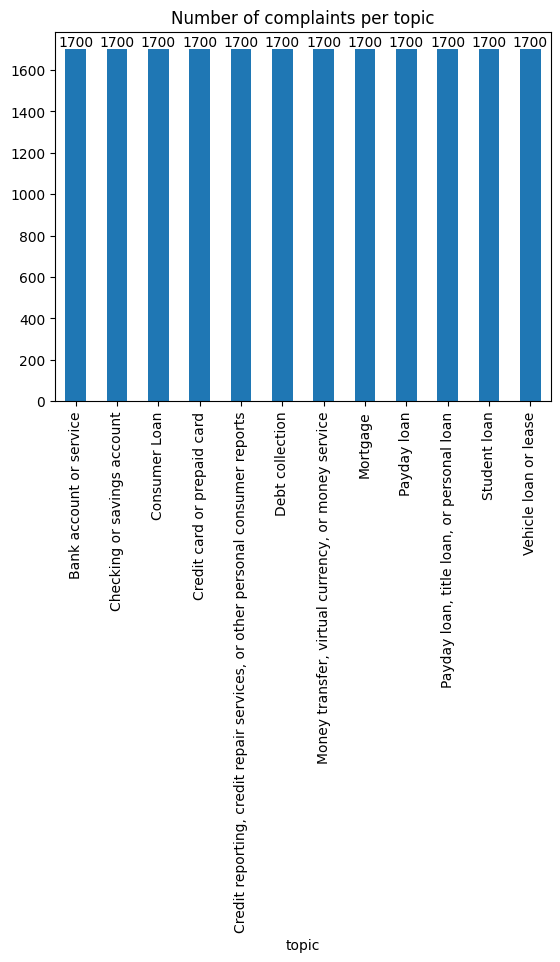

In [16]:
data = df['topic'].value_counts().sort_values(ascending=False)

data.plot(kind='bar', title='Number of complaints per topic')

for index, value in enumerate(data):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

In [17]:
print_plot(100)

account closed cable bill equipment returned account closed handed collections returned equipment store however account still open collections agency sent certified letter receipt attached showing returned equipment letter requesting validation debt response certified letter response 30 business days filled dispute receipt returned equipment well removed credit file however showing purchased another debt collection agency longer liable account
Topic:  Debt collection


In [18]:
sentences = df["input"].tolist()
sentences[0:2]

['funding suite located ca # entered credit report inquiry credit reports upon contacting could find told due someone trying attain credit fraudulently authorize inquiry',
 'received money order tenant misplaced one year three years old purchased western union financial services western union claims longer good needs reissued large fee understand money order state teas abandoned unless three years old date purchase teas property code chapter 72 sub chapter b page 4 appears money order companies makes rules regulation coincide state federal laws rip consumers misfortune accident called western union want large fee replace fee already paid purchase would honor check western union states back check good year date purchase non refundable service charge deducted face value check assessed prohibited law called check drawn could help called federal trade commission directed matter office']

In [19]:
bert = 'intfloat/multilingual-e5-large-instruct'
sentence_transformer = SentenceTransformer(bert)
embeddings = sentence_transformer.encode(sentences, show_progress_bar=True)
print(f"Embedding shape: {embeddings.shape}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Batches:   0%|          | 0/638 [00:00<?, ?it/s]

Embedding shape: (20400, 1024)


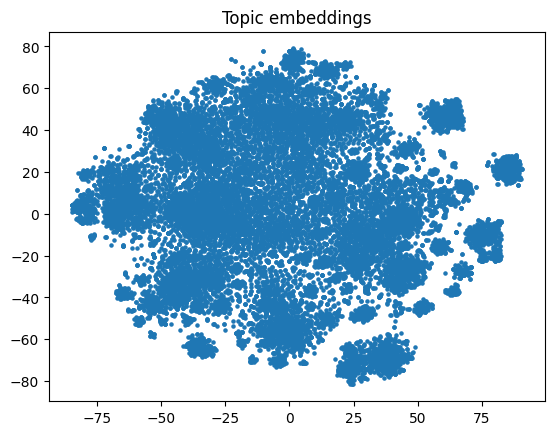

In [20]:
def visualize_embeddings(embeddings, size=10, labels=None, title=''):
  tsne = TSNE(n_components=2, learning_rate='auto')
  tsne_embeddings = tsne.fit_transform(embeddings)

  plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], s=size, c=labels)
  plt.title(title)
  plt.show()

visualize_embeddings(embeddings, size=5, title='Topic embeddings')

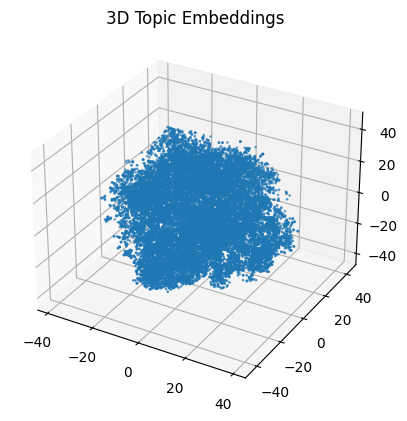

In [21]:
def visualize_embeddings_3d(embeddings, size=10, labels=None, title=''):
    tsne = TSNE(n_components=3, learning_rate='auto', init='random')
    tsne_embeddings = tsne.fit_transform(embeddings)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], tsne_embeddings[:, 2], s=size, c=labels)

    if labels is not None:
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)

    plt.title(title)
    plt.show()

visualize_embeddings_3d(embeddings, size=1, title='3D Topic Embeddings')

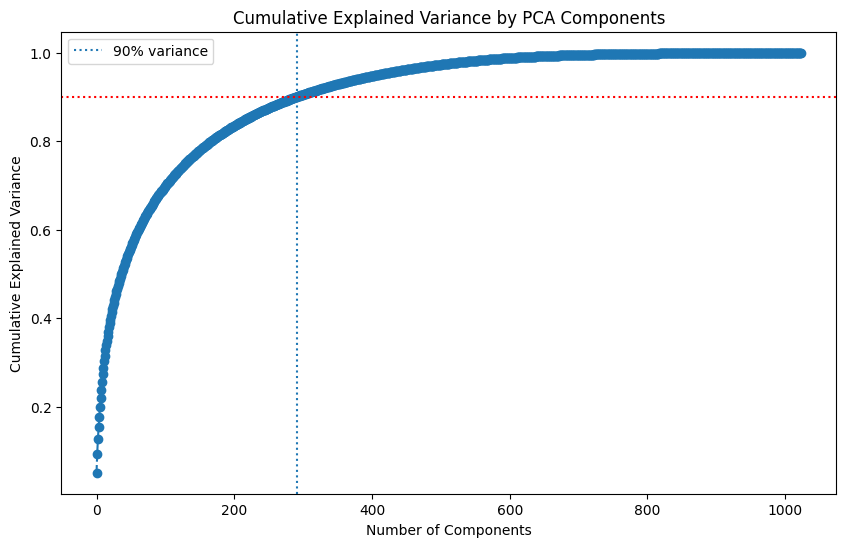

Number of components to retain 90% of variance: 291


In [22]:
pca_full = PCA(random_state=42)
pca_full.fit(embeddings)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_90_variance = np.where(cumulative_variance >= 0.9)[0][0] + 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=n_components_90_variance, linestyle=':', label='90% variance')
plt.axhline(y=0.9, linestyle=':', color='red')
plt.legend(loc='best')

plt.show()

print(f"Number of components to retain 90% of variance: {n_components_90_variance}")

In [23]:
pca = PCA(n_components=n_components_90_variance, svd_solver='full', random_state=42)
dim_reduced_embeddings = pca.fit_transform(embeddings)
print(f"Dimension reduced embedding shape: {dim_reduced_embeddings.shape}")

Dimension reduced embedding shape: (20400, 291)


In [24]:
df["EMBEDDING"] = list(dim_reduced_embeddings)
df

,topic,input,EMBEDDING
0,Bank account or service,funding suite located ca # entered credit repo...,"[-0.014547219, 0.116940714, -0.09017317, -0.09..."
1,Bank account or service,received money order tenant misplaced one year...,"[0.044115312, -0.07369089, -0.023365246, 0.012..."
2,Bank account or service,hello fdic consumer protection us bank califor...,"[0.08794012, -0.00487491, 0.004819505, 0.04398..."
3,Bank account or service,capitalone pay following promotion even comple...,"[0.08220153, 0.023878137, 0.13723256, -0.01531..."
4,Bank account or service,received check citizens bank response consent ...,"[0.045912277, 0.011973057, -0.011381818, -0.02..."
...,...,...,...
20395,Vehicle loan or lease,previously filed matter sold faulty product de...,"[-0.0891178, -0.05664605, -0.10283626, 0.01451..."
20396,Vehicle loan or lease,entered contract car dealership illinois finan...,"[-0.0912548, -0.00090583984, -0.07426427, 0.06..."
20397,Vehicle loan or lease,particular account situation lately filing cre...,"[-0.051105753, -0.030892273, -0.04953666, -0.1..."
20398,Vehicle loan or lease,based research loan established paid full late...,"[-0.114553384, 0.017029162, 0.016041579, -0.03..."


In [25]:
topic_df = df.drop(columns=["topic"])
topic_df = topic_df.groupby("input").mean().reset_index()

Candidate 5 values Round
Candidate 6 values Round
Candidate 7 values Round
Candidate 8 values Round
Candidate 9 values Round
Candidate 10 values Round
Candidate 11 values Round
Candidate 12 values Round
Candidate 13 values Round
Candidate 14 values Round
Silhouette scores: {5: 0.0345679, 6: 0.03772648, 7: 0.040130742, 8: 0.041198537, 9: 0.04432858, 10: 0.042674817, 11: 0.042875834, 12: 0.03827254, 13: 0.040499285, 14: 0.04193622}


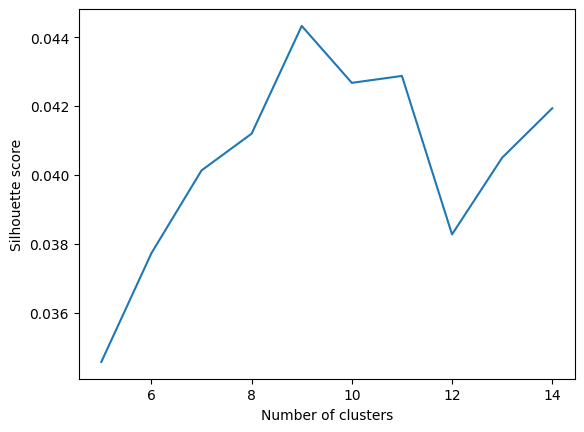

In [26]:
input_embeddings = [embedding for embedding in topic_df["EMBEDDING"].values]

candidate_k_values = list(range(5, 15))
slht_score, kmeans_labels = [], []
for k in candidate_k_values:
  kmeans = KMeans(n_clusters = k, n_init = 20)
  kmeans.fit(input_embeddings)

  kmeans_labels.append(kmeans.labels_)
  slht_score.append(silhouette_score(input_embeddings, kmeans.labels_))
  print(f"Candidate {k} values Round")

silhouette_score_dict = {candidate_k_values[i]: slht_score[i] for i in range(len(slht_score))}

print(f"Silhouette scores: {silhouette_score_dict}")
plt.plot(candidate_k_values, slht_score)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [27]:
best_k = max(silhouette_score_dict, key=silhouette_score_dict.get)
print(f"Best k: {best_k}")

Best k: 9


In [28]:
topic_df["CLUSTER"] = kmeans_labels[best_k - candidate_k_values[0]]

In [29]:
topic_embeddings = np.array([embedding for embedding in topic_df["EMBEDDING"].values])

In [30]:
tsne = TSNE(n_components=3, learning_rate='auto', init='random')
tsne_embeddings = tsne.fit_transform(topic_embeddings)

In [31]:
tsne_embeddings

array([[  9.332278 ,  -5.563346 ,   5.0276957],
       [  9.450032 ,  -1.0266894,  30.24896  ],
       [ 12.353482 ,  15.27038  , -25.16331  ],
       ...,
       [  4.7609973,  27.084618 ,  24.75081  ],
       [  3.1470242, -36.318882 ,  -2.5063114],
       [ 11.285377 , -30.666489 ,   6.5213203]], dtype=float32)

In [32]:
topic_df["CLUSTER"].values

array([2, 5, 7, ..., 5, 2, 2], dtype=int32)

In [33]:
import plotly.graph_objs as go
import plotly.offline as pyo


pyo.init_notebook_mode(connected=True)

trace = go.Scatter3d(
    x=tsne_embeddings[:, 0], 
    y=tsne_embeddings[:, 1],
    z=tsne_embeddings[:, 2], 
    mode='markers',     
    marker={
        'size': 1.5,
        'opacity': 0.9,
        'color':topic_df["CLUSTER"].values
    },
    text=topic_df["CLUSTER"].values,
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]
plot_figure = go.Figure(data=data, layout=layout)
pyo.iplot(plot_figure)


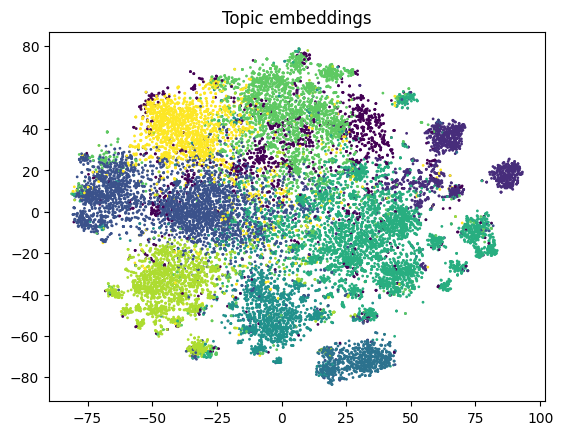

In [34]:
topic_embeddings = np.array([embedding for embedding in topic_df["EMBEDDING"].values])
visualize_embeddings(topic_embeddings, size=1, labels=topic_df["CLUSTER"].values, title='Topic embeddings')

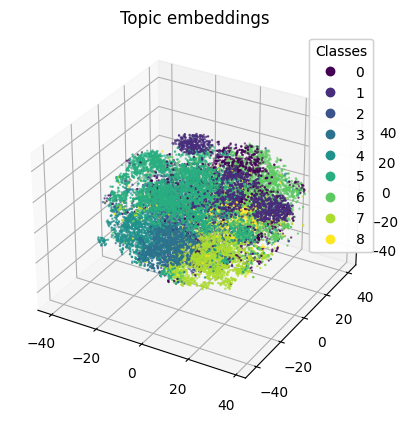

In [35]:
visualize_embeddings_3d(topic_embeddings, size=0.5, labels=topic_df["CLUSTER"].values, title='Topic embeddings')

In [36]:
def most_common_words(x):
  word_salad = ' '.join(x).lower().split()
  ctr = Counter(word_salad)
  return ctr.most_common(3)

topic_clustered_df = df.merge(topic_df, on='input', how='left')
result = topic_clustered_df.groupby("CLUSTER")['input'].apply(most_common_words).reset_index()
print(result)

   CLUSTER                                              input
0        0       [(account, 563), (credit, 415), (loan, 274)]
1        1   [(account, 2988), (paypal, 2366), (money, 2210)]
2        2  [(loan, 9966), (payment, 5264), (payments, 4077)]
3        3    [(wells, 3053), (fargo, 3008), (account, 1981)]
4        4  [(loan, 3999), (mortgage, 3544), (payment, 2749)]
5        5    [(account, 15433), (bank, 10997), (card, 5447)]
6        6  [(credit, 7621), (account, 4085), (report, 3870)]
7        7    [(car, 4700), (payment, 3253), (vehicle, 2961)]
8        8        [(call, 1866), (phone, 1564), (debt, 1533)]


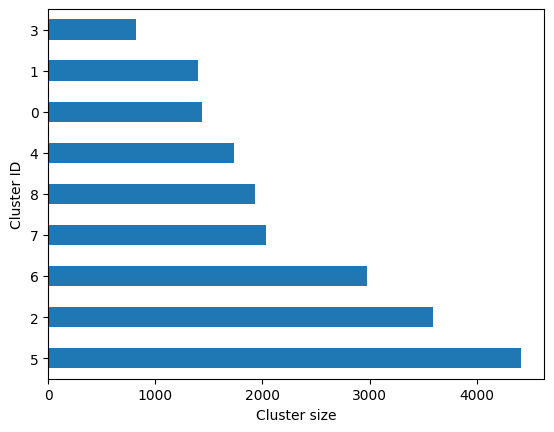

In [37]:
def plot_cluster_sizes(df, column_name):
    df[column_name].value_counts().plot(kind='barh')
    plt.xlabel('Cluster size')
    plt.ylabel('Cluster ID')
    plt.show()

plot_cluster_sizes(topic_df, "CLUSTER")